In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from scipy.stats import kstest, shapiro, mannwhitneyu
from scipy.stats import kruskal
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
pd.set_option('display.max_columns', None)

Ритейл-компания `ABC Private Limited` хочет понять **поведение пользователей** в разрезе различных продуктов из различных категорий. Перед нами датасет продаж за **последний** месяц

Также данный датасет включает себя **характеристики пользователей** (возраст, пол, семейное положение, город), продукт и его категорию, **общую сумму** покупок за последний месяц

Их цель сделать **модель**, предсказывающую **сумму покупок пользователей**, что поможет создавать персональное предложение для каждого пользователя в будущем

In [4]:
retail_df = pd.read_csv('black_friday.csv')
print(f'Размерность датафрейма: {retail_df.shape}')
print()
retail_df.head()

Размерность датафрейма: (550068, 12)



,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


Для начала проделаем операцию по уменьшению оперативной памяти, а именно `int64 и float64` приведем к более **маленьким типам**

In [7]:
retail_copy = retail_df.copy()
retail_copy['Gender'] = retail_copy['Gender'].map({'F' : 0, 'M' : 1})

int_float_cols = [col for col in retail_copy.columns if retail_copy[col].dtype == int or retail_copy[col].dtype == float]

for col in int_float_cols:
    retail_copy[col] = pd.to_numeric(retail_copy[col], downcast='unsigned')

del retail_df

retail_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  uint32 
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  uint8  
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  uint8  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  uint8  
 8   Product_Category_1          550068 non-null  uint8  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  uint16 
dtypes: float64(2), object(4), uint16(1), uint32(1), uint8(4)
memory usage: 3

In [8]:
retail_copy.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,0,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,0,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,0,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,0,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,1,55+,16,C,4+,0,8,NaN,NaN,7969


Теперь мы немного **уменьшили** количество занимаемой оперативной памяти.

# Посчитать базовые значения статистик
Будем считать **среднее, медианное и модальное** (не для всех) значения. Эти значения мы можем посчитать только для вещественных колонок (колонки - они же признаки в дальнейшем)

Единственная колонка по которой можно посчитать **какое-либо значение** - это `Purchase`, чек на покупку у каждого пользователя. Для остальных колонок подсчет базовых статистик **не имеет смысла**, поэтому не применяю метод `describe()`

In [10]:
colum = 'Purchase'
mean_value = retail_copy[colum].mean()
median_value = retail_copy[colum].median()
std_value = retail_copy[colum].std()
print(f'Median = {median_value}')
print(f'Mean = {mean_value}')
print(f'Std = {std_value}')

Median = 8047.0
Mean = 9263.968712959126
Std = 5023.065393820582


# Пропущенные значения
Что ж, если мы посмотрим на информацию о **каждой колонке**, то увидим, что **пропущенные** значения встречаются в 2-х стобцах (категория товара 2 и 3). Посмотрим сначала на встречающиеся значения в них, затем примем **дальнейшее решение**

In [12]:
columnss = ['Product_Category_2', 'Product_Category_3']
zero_flag = False

for col in columnss:
    list_col = list(retail_copy[col])
    for a in list_col:
        if a == 0:
            zero_flag = True
            break

print(f'Есть ли нули в датафрейме? Ответ - {zero_flag}')

Есть ли нули в датафрейме? Ответ - False


Так как **нулей у нас нет** ни в одной из колонок, где есть **пропущенные значения**, смело заменяем все `NaN-значения` на нули

In [14]:
retail_copy.fillna(0, inplace=True)

Больше у нас нет пропущенных значений

# Уникальные значения
Проверка на **уникальные значения** помогает нам верно отнести колонку к **вещественному** или **категориальному** признаку. Посмотрим на **количество уникальных** значений по каждому столбцу:

In [16]:
for col in retail_copy.columns:
    print(f'Колонка: {col}')
    print(f'Количество уникальных значений: {retail_copy[col].nunique()}')
    print('Cами значения:')
    print(retail_copy[col].unique())

Колонка: User_ID
Количество уникальных значений: 5891
Cами значения:
[1000001 1000002 1000003 ... 1004113 1005391 1001529]
Колонка: Product_ID
Количество уникальных значений: 3631
Cами значения:
['P00069042' 'P00248942' 'P00087842' ... 'P00370293' 'P00371644'
 'P00370853']
Колонка: Gender
Количество уникальных значений: 2
Cами значения:
[0 1]
Колонка: Age
Количество уникальных значений: 7
Cами значения:
['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Колонка: Occupation
Количество уникальных значений: 21
Cами значения:
[10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
Колонка: City_Category
Количество уникальных значений: 3
Cами значения:
['A' 'C' 'B']
Колонка: Stay_In_Current_City_Years
Количество уникальных значений: 5
Cами значения:
['2' '4+' '3' '1' '0']
Колонка: Marital_Status
Количество уникальных значений: 2
Cами значения:
[0 1]
Колонка: Product_Category_1
Количество уникальных значений: 20
Cами значения:
[ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17 

Значит, мы можем считать **категориальными колонки** (они в датасете на самом деле числовые): `Gender`, `Marital_Status`, а также все остальные, кроме `ID` и `чека`. К счастью, так как они уже представлены **числовым типом** данных - их не надо будет кодировать в дальнейшем. Поэтому просто имеем ввиду что они на самом деле **Категориальные**!

# Выбросы 
Пришло время почистить выбросы в колонке с ценой. Для начала визуализируем распределение с помощью **боксплота**

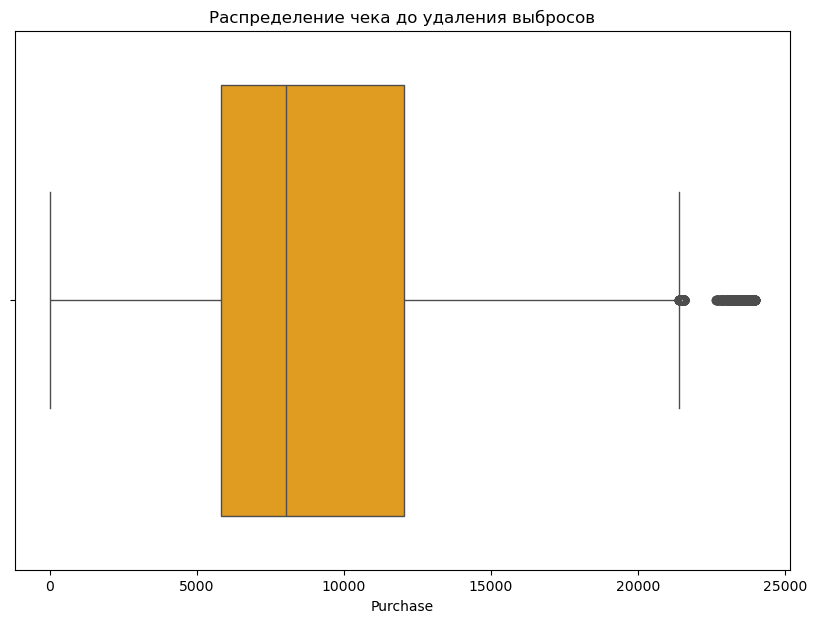

In [19]:
plt.figure(figsize=(10, 7));
sns.boxplot(data=retail_copy, x='Purchase', color='orange');
plt.title('Распределение чека до удаления выбросов');

Видим выбросы правее 99-й перцентили. Теперь почистим все выбросы

In [21]:
left = 0.01
right = 0.99

retail_df = retail_copy.copy()

In [22]:
col = 'Purchase'
left_bound, right_bound = retail_df[col].quantile([left, right])
retail_df = retail_df[(retail_df[col] >= left_bound - 1) & (retail_df[col] <= right_bound + 1)]
print('Размер датафрейма после удаления выбросов:', retail_df.shape[0])

Размер датафрейма после удаления выбросов: 539149


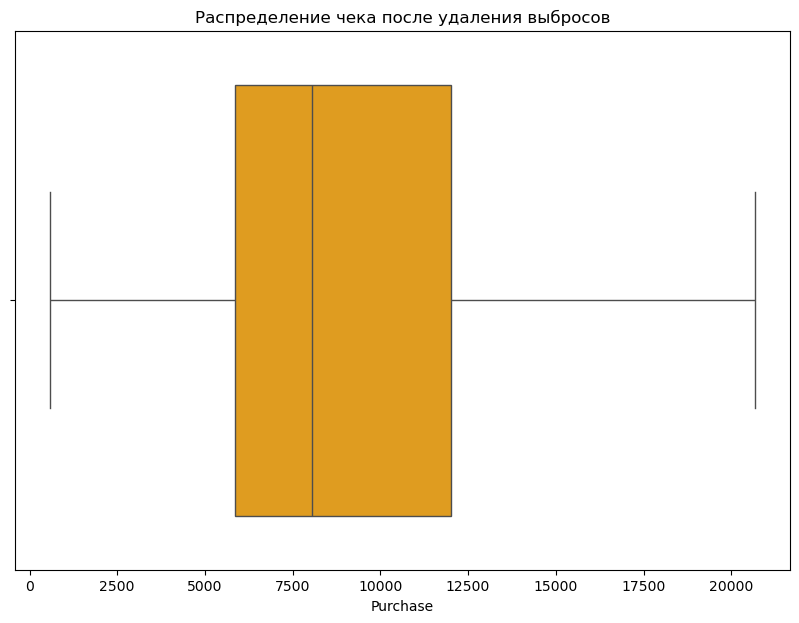

In [23]:
plt.figure(figsize=(10, 7));
sns.boxplot(data=retail_df, x='Purchase', color='orange');
plt.title('Распределение чека после удаления выбросов');

# Распределение чека покупки
Построим **распределение чека** покупки purchase

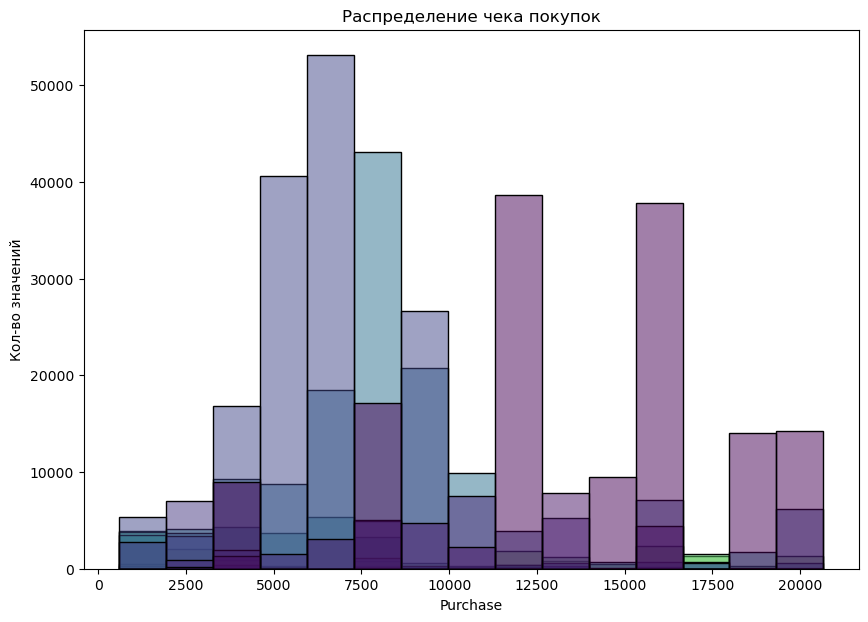

In [25]:
plt.figure(figsize=(10, 7));
sns.histplot(data=retail_df, x='Purchase', bins=15, palette='viridis', hue='Product_Category_1', legend=False);
plt.ylabel('Кол-во значений');
plt.title('Распределение чека покупок');

# Зависимость возрастной группы от чека 
Посмотрим на то, как зависит **возрастная когорта** пользователей от **среднего и медианного** чека, то есть посчитаем по каждой группе **среднее и медианное** значение

In [27]:
df = retail_df.groupby('Age').agg({'Purchase' : 'mean'})
df

,Purchase
Age,
0-17,8901.338651
18-25,9159.073063
26-35,9215.693540
36-45,9283.441553
46-50,9158.982642
51-55,9443.123232
55+,9293.634094


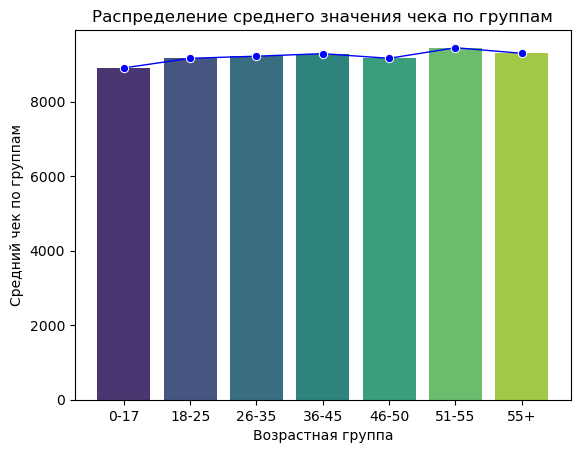

In [28]:
df.reset_index(inplace=True)
sns.barplot(data=df, x='Age', y='Purchase', palette='viridis', hue='Age');
sns.lineplot(x='Age', y='Purchase', data=df, marker='o', color='blue', linewidth=1);
plt.xlabel('Возрастная группа');
plt.ylabel('Средний чек по группам');
plt.title('Распределение среднего значения чека по группам');

In [29]:
df = retail_df.groupby('Age').agg({'Purchase' : 'median'})
df

,Purchase
Age,
0-17,7989.0
18-25,8031.0
26-35,8029.0
36-45,8060.0
46-50,8035.0
51-55,8124.0
55+,8108.0


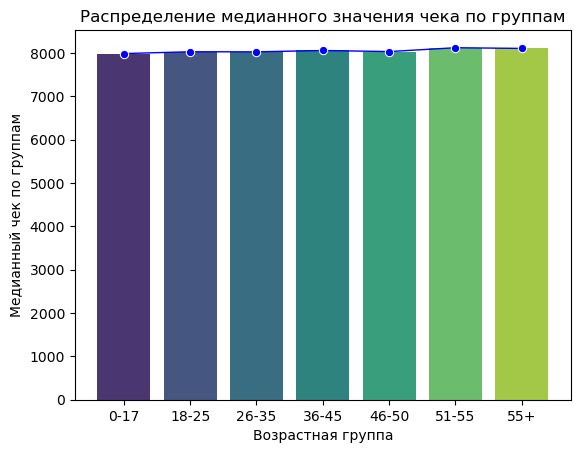

In [30]:
df.reset_index(inplace=True)
sns.barplot(data=df, x='Age', y='Purchase', palette='viridis', hue='Age');
sns.lineplot(x='Age', y='Purchase', data=df, marker='o', color='blue', linewidth=1);
plt.xlabel('Возрастная группа');
plt.ylabel('Медианный чек по группам');
plt.title('Распределение медианного значения чека по группам');

In [31]:
df = retail_df.groupby('Age').agg({'Purchase' : 'count'})
df

,Purchase
Age,
0-17,14794
18-25,97984
26-35,215558
36-45,107661
46-50,44706
51-55,37539
55+,20907


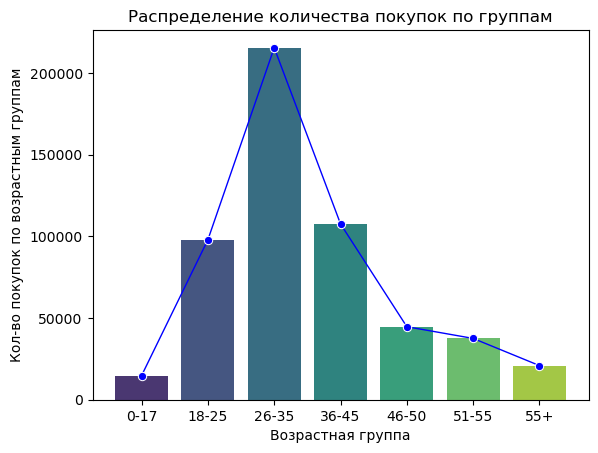

In [32]:
df.reset_index(inplace=True)
sns.barplot(data=df, x='Age', y='Purchase', palette='viridis', hue='Age');
sns.lineplot(x='Age', y='Purchase', data=df, marker='o', color='blue', linewidth=1);
plt.xlabel('Возрастная группа');
plt.ylabel('Кол-во покупок по возрастным группам');
plt.title('Распределение количества покупок по группам');

Думаю, **без выдвижения** гипотез всё наглядно видно. **Средние и медианные** значения по каждым группам очень близки друг к другу. Чтобы точно убедиться в этом, применим критерий `Краскела-Уоллиса` для **множественного сравнения выборок**

In [34]:
sample1 = retail_df[retail_df['Age'] == '0-17']['Purchase']
sample2 = retail_df[retail_df['Age'] == '18-25']['Purchase']
sample3 = retail_df[retail_df['Age'] == '26-35']['Purchase']
print(f'Pvalue = {kruskal(sample1, sample2, sample3).pvalue}')

Pvalue = 3.2922402523859956e-14


Значение `P-value` очень низкое даже между нашими **тремя** выборками. Что ж, не всегда можно **статистически** подтвердить, что наши выборки похожи друг на друга. Это происходит из-за различий в **количестве элементов** в каждой выборке, поэтому в данном контексте некорректно их сравнивать

По графикам, которые представлены выше, можно сделать вывод, что средние и медианные значения по возрастным группам **близки** к друг другу. 

Поэтому самым верным вариантом будет подсчитать **количество** покупок по возрастным категориям. Можно заметить, что пользователи из возрастной когорты `26-35` лет совершают большее количество покупок **(39% всех покупок)**, а значит **именно они и приносят нашему сервису наибольшее кол-во прибыли**

# Общее количество уникальных пользователей по группам
Посчитаем **количество уникальных** пользователей по группам и визуализируем

In [37]:
df_ids = pd.DataFrame(retail_df.groupby('Age')['User_ID'].nunique()).reset_index()
df_ids

,Age,User_ID
0,0-17,218
1,18-25,1069
2,26-35,2053
3,36-45,1167
4,46-50,531
5,51-55,481
6,55+,372


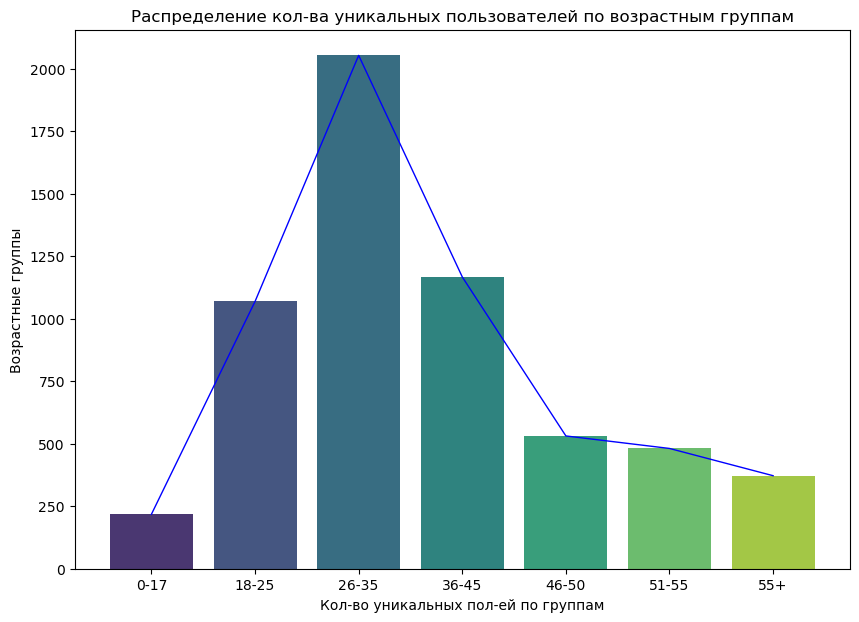

In [38]:
plt.figure(figsize=(10, 7));
sns.barplot(data=df_ids, x='Age', y='User_ID', palette='viridis', hue='Age');
sns.lineplot(data=df_ids, x='Age', y='User_ID', color='blue', linewidth=1);
plt.xlabel('Кол-во уникальных пол-ей по группам');
plt.ylabel('Возрастные группы');
plt.title('Распределение кол-ва уникальных пользователей по возрастным группам');

Видим **практически идентичный** график количеству покупок в зависимости от возрастной группы. **Больше всего** уникальный пользователей в группе `26-35` лет

# Распределение по полу
Посчитаем **количество** уникальных пользователей **мужского и женского** пола, затем посмотрим, кто и **сколько** из них тратит в среднем

In [41]:
df_male = pd.DataFrame(retail_df.groupby('Gender')['User_ID'].nunique()).reset_index()
df_male.head()

,Gender,User_ID
0,0,1666
1,1,4225


На удивление, наибольшее количество уникальных пользователей - **мужчины**. Теперь посчитаем **количество покупок** от пользователей мужского и женского пола:

In [43]:
df_orders = pd.DataFrame(retail_df.groupby('Gender').agg({'Product_ID' : 'count'})).reset_index() # 1-й способ

df_orders = pd.DataFrame(retail_df['Gender'].value_counts(sort=False)) # 2-й способ

df_orders.rename(columns={'Product_ID' : 'Orders_Count'}, inplace=True)
df_orders.head()

,count
Gender,
0,133165
1,405984


Получается, что и покупок, которые совершили мужчины, практически в **3 раза больше**. Теперь посмотрим на **средние и медианные** значения чека у мужчин и у женщин. Возможно, **средний** чек у мужчин в 3 раза будет ниже, чем у женщины

In [45]:
df_median = pd.DataFrame(retail_df.groupby('Gender')['Purchase'].agg('median')).reset_index()
df_median

,Gender,Purchase
0,0,7917.0
1,1,8097.0


In [46]:
df_mean = pd.DataFrame(retail_df.groupby('Gender').agg({'Purchase' : 'mean'})).reset_index()
df_mean

,Gender,Purchase
0,0,8705.869523
1,1,9394.562007


In [47]:
df_std = pd.DataFrame(retail_df.groupby('Gender').agg({'Purchase' : 'std'})).reset_index()
df_std

,Gender,Purchase
0,0,4558.222491
1,1,4892.897490


Видим очевидные различия в среднем и довольно небольшие в медианном значение. Так же **среднеквадратичное отклонение** отличается меньше, чем на 10%. Подтвердим **статистически**, что выборки действительно статистически отличаются. Для этого проверим, взяты ли они из нормального распределения. Если нет - применим **критерий Колмогорова-Смирнова**, для понимания вообще, из одного ли распределения выборки, если нет - используем **критерий Маннa-Уитни**

<Figure size 1000x700 with 0 Axes>

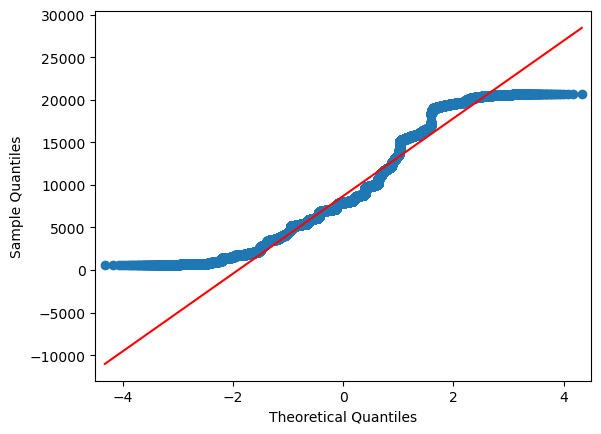

In [49]:
data_norm0 = retail_df[retail_df['Gender'] == 0]['Purchase']
plt.figure(figsize=(10, 7));
qqplot(data=data_norm0, line='s');

<Figure size 1000x700 with 0 Axes>

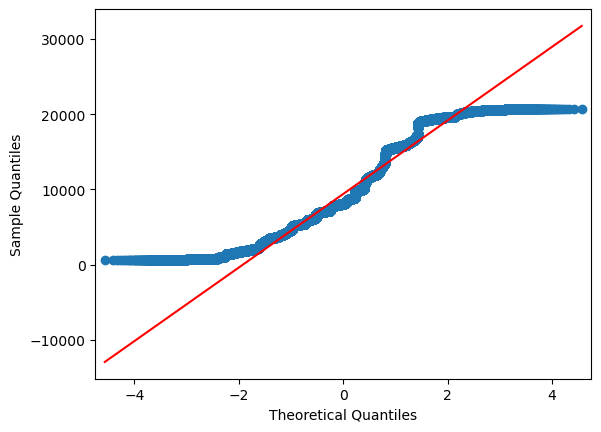

In [50]:
data_norm1 = retail_df[retail_df['Gender'] == 1]['Purchase']
plt.figure(figsize=(10, 7));
qqplot(data=data_norm1, line='s');

Обе выборки взяты не из нормальных распределений. Что ж, проверим, а вообще, **из одной они выборки** или нет?

In [52]:
pv = kstest(data_norm0, data_norm1).pvalue
print('P-value for K-S Test:', pv)

P-value for K-S Test: 0.0


Видим, что выборки из **разных** распределений, обе выборки **не соответствуют** нормальному распределению. Применим критерий Манна-Уитни, который покажет нам, различаются ли эти распределения систематически. Но для сравнения средних он не подходит! Ну и затем построим боксплоты, чтобы точно понять результаты

In [54]:
print('P-value for Mann-Whitney:', mannwhitneyu(data_norm0, data_norm1).pvalue)
print('Statistic for Mann-Whitney:', mannwhitneyu(data_norm0, data_norm1).statistic)

P-value for Mann-Whitney: 0.0
Statistic for Mann-Whitney: 25051040049.0


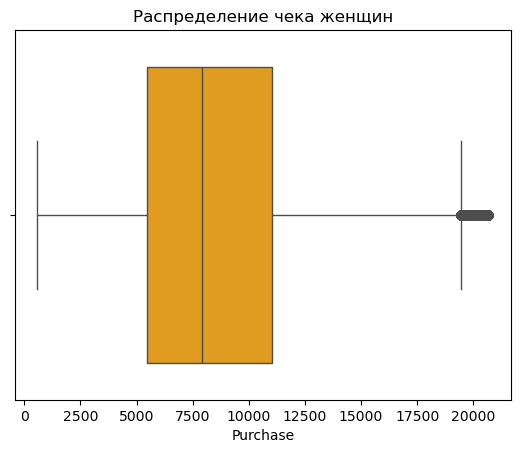

In [55]:
sns.boxplot(data=pd.DataFrame(data_norm0).reset_index(), x='Purchase', color='orange');
plt.title('Распределение чека женщин');

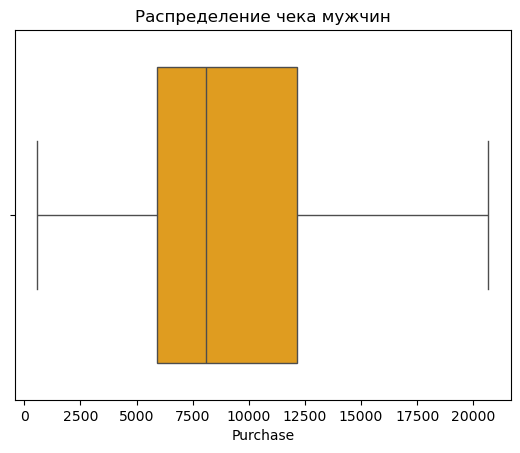

In [56]:
sns.boxplot(data=pd.DataFrame(data_norm1).reset_index(), x='Purchase', color='orange');
plt.title('Распределение чека мужчин');

Не смотря на внешние сходства и практически идентичные медианные значения (и средние очень близкие друг к другу), распределения на самом деле различаются, что доказывают нам криктерии Колмогорова-Смирнова и Манна-Уитни. 

Ну и так как средние и медианные значения расположены довольно близко друг к другу - сделаем вывод, что нет разницы, кто покупает, так как средние и медианные значения тоже одинаковы (также как и по возрастным группам). Значит, нас интересует количество пользователей определенного пола (а конкретно - мужского) и количество пользователей из определенной возрастной группы (26-35 лет). 

Так же можно проверить количество покупок, совершенных пользователями из возрастной группы 26-35 лет, в зависимости от пола пользователя

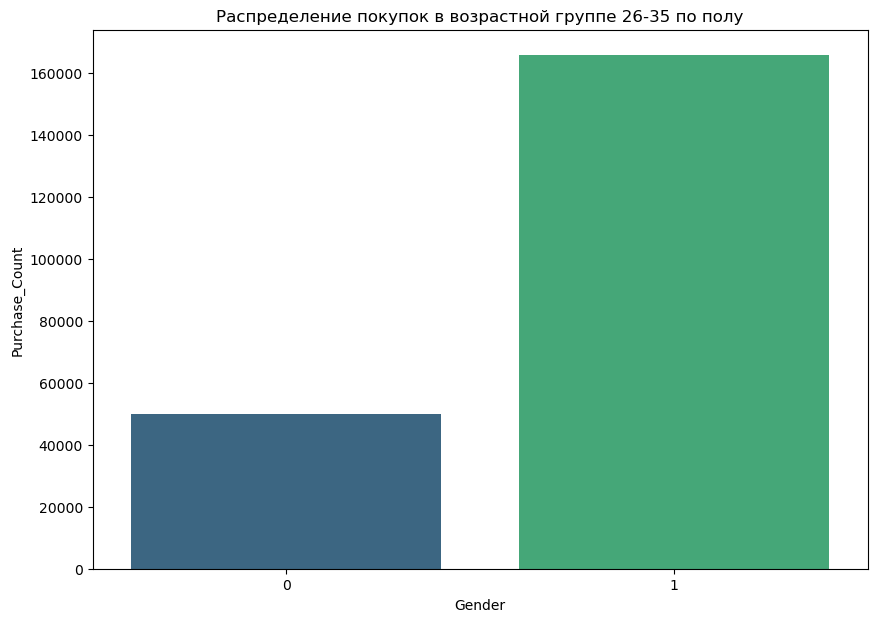

In [58]:
df_age_twenty_six = pd.DataFrame(retail_df[retail_df['Age'] == '26-35'].groupby('Gender')['Purchase'].agg('count')).reset_index()
plt.figure(figsize=(10, 7));
sns.barplot(data=df_age_twenty_six, x='Gender', y='Purchase', palette='viridis', hue='Gender', legend=False);
plt.title('Распределение покупок в возрастной группе 26-35 по полу');
plt.ylabel('Purchase_Count');

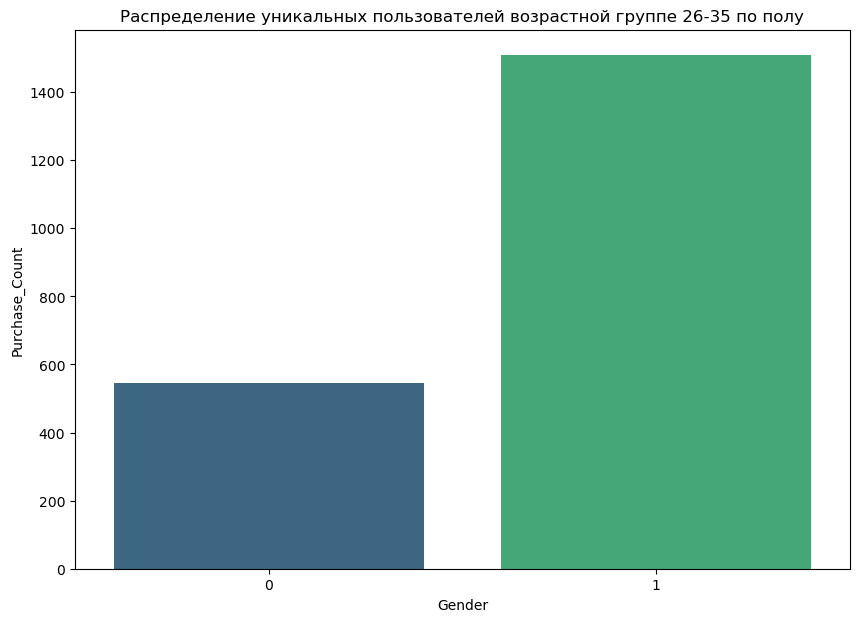

In [59]:
df_age_twenty_six = pd.DataFrame(retail_df[retail_df['Age'] == '26-35'].groupby('Gender')['User_ID'].nunique()).reset_index()
plt.figure(figsize=(10, 7));
sns.barplot(data=df_age_twenty_six, x='Gender', y='User_ID', palette='viridis', hue='Gender', legend=False);
plt.title('Распределение уникальных пользователей возрастной группе 26-35 по полу');
plt.ylabel('Purchase_Count');

Ну и **для уверенности** - средние и медиальные значения

In [61]:
df_age_twenty_six = pd.DataFrame(retail_df[retail_df['Age'] == '26-35'].groupby('Gender')['Purchase'].agg('mean')).reset_index()
df_age_twenty_six

,Gender,Purchase
0,0,8696.118823
1,1,9371.952534


In [62]:
df_age_twenty_six = pd.DataFrame(retail_df[retail_df['Age'] == '26-35'].groupby('Gender')['Purchase'].agg('median')).reset_index()
df_age_twenty_six

,Gender,Purchase
0,0,7888.0
1,1,8080.0


***ВЫВОД:*** медианноe и среднее значение выше у пользователей мужского пола в самой большой возрастной группе. Кол-во уникальных пользователей мужского пола в ней тоже больше. Значит, **целевой пользователь для нашей компании - мужчина в возрасте от 25 до 36 лет**

# Машинное обучение

Пришло время применить **линейную регрессию** к датасету. Перед этим были **удалены пропущенные значения и выбросы** в зависимой переменной. Теперь необходимо **закодировать** все категориальные признаки с помощью `one-hot encoding`, а также **стандартизировать** для более точных предсказаний. Будет использован метод **аналитического решения**

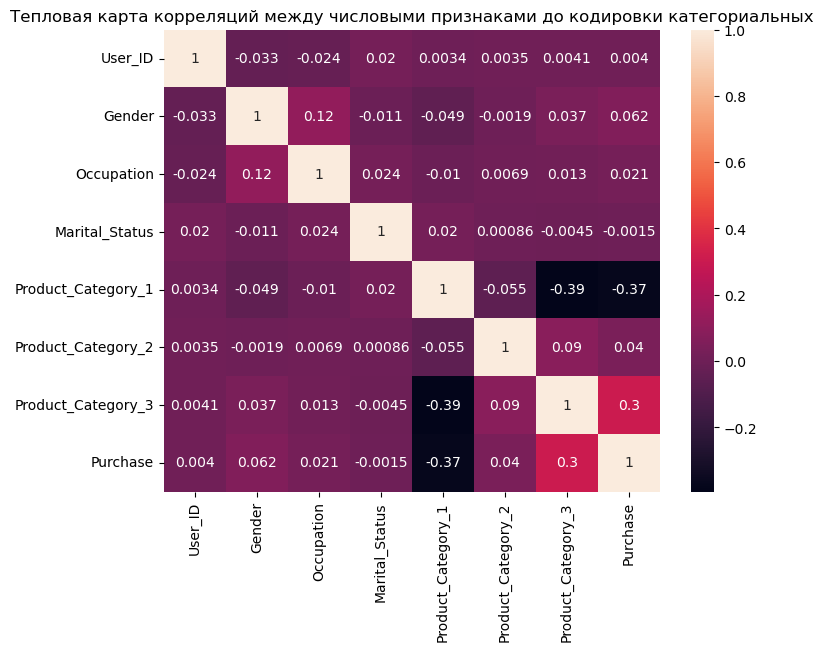

In [65]:
cat_cols = [col for col in retail_df.columns if retail_df[col].dtype == 'object']
int_float_cols = [col for col in retail_df.columns if retail_df[col].dtype != 'object']

plt.figure(figsize=(8, 6));
sns.heatmap(data=retail_df[int_float_cols].corr(), annot=True);
plt.title('Тепловая карта корреляций между числовыми признаками до кодировки категориальных');

In [66]:
retail_copy = retail_df.copy()
for col in cat_cols:
    if col != 'Product_ID':
        one_hot = pd.get_dummies(retail_copy[col], prefix=col, drop_first=True, dtype='int')
        retail_copy = pd.concat([retail_copy, one_hot], axis=1)
        retail_copy.drop(col, axis=1, inplace=True)
    else:
        mean_target = retail_copy.groupby(col)['Purchase'].mean()
        retail_copy[col] = retail_copy[col].map(mean_target)

retail_copy.head()

,User_ID,Product_ID,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,1000001,11870.863436,0,10,0,3,0.0,0.0,8370,0,0,0,0,0,0,0,0,0,1,0,0
1,1000001,16304.030981,0,10,0,1,6.0,14.0,15200,0,0,0,0,0,0,0,0,0,1,0,0
2,1000001,1321.666667,0,10,0,12,0.0,0.0,1422,0,0,0,0,0,0,0,0,0,1,0,0
3,1000001,1464.647929,0,10,0,12,14.0,0.0,1057,0,0,0,0,0,0,0,0,0,1,0,0
4,1000002,7692.763547,1,16,0,8,0.0,0.0,7969,0,0,0,0,0,1,0,1,0,0,0,1


In [67]:
int_float_colss = [col for col in retail_copy.columns if retail_copy[col].dtype != 'object']
dict_of_corr = dict((retail_copy[int_float_colss].corr())['Purchase'].sort_values())

norm_corr_cols = []
for key, value in dict_of_corr.items():
    if np.abs(value) >= 0.01:
        norm_corr_cols.append(key)
        
(retail_copy[int_float_colss].corr())['Purchase'].sort_values()

Product_Category_1              -0.372653
City_Category_B                 -0.021890
Age_18-25                       -0.006391
Age_46-50                       -0.004084
Stay_In_Current_City_Years_1    -0.002416
Age_26-35                       -0.001484
Marital_Status                  -0.001465
Stay_In_Current_City_Years_4+    0.000774
Stay_In_Current_City_Years_3     0.001770
Age_55+                          0.002882
User_ID                          0.003954
Age_36-45                        0.006110
Stay_In_Current_City_Years_2     0.007091
Age_51-55                        0.012406
Occupation                       0.021055
Product_Category_2               0.039970
Gender                           0.061600
City_Category_C                  0.068013
Product_Category_3               0.304412
Product_ID                       0.838463
Purchase                         1.000000
Name: Purchase, dtype: float64

**Закодировали почти все категориальные** признаки с помощью `one-hot encoding`, только Product_ID с помощью `mean-target encoding` (так как 3600 уникальных значений). Удалили все признаки с **корреляцией ниже 1%** (ниже 0.01 по модулю). Теперь можно перейти к **стандартизации** данных и к обучению

In [69]:
X = np.array(retail_copy[[col for col in norm_corr_cols if col != 'Purchase']])
Y = np.array(retail_copy['Purchase']).reshape(-1, 1)

scaler_X = StandardScaler()
scaler_X.fit(X)
scaled_X = scaler_X.transform(X)


scaler_Y = StandardScaler()
scaler_Y.fit(Y)
scaled_Y = scaler_Y.transform(Y)

Теперь разобьем данные на **тестовые и тренировочные** с помощью метода train_test_split

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, scaled_Y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [72]:
Y_pr = model.predict(X_test)
Y_pred = scaler_Y.inverse_transform(Y_pr)
Y_test_real = scaler_Y.inverse_transform(Y_test)
print('MAE:', mean_absolute_error(Y_pred, Y_test_real))
print('MSE:', mean_squared_error(Y_pred, Y_test_real))
print('RMSE:', np.sqrt(mean_squared_error(Y_pred, Y_test_real))) 
print('Mean value in test:', np.mean(scaler_Y.inverse_transform(Y_test)))

MAE: 1951.3670790926037
MSE: 6899968.305156165
RMSE: 2626.7790742953935
Mean value in test: 9232.883223592693


Модель на основе **аналитического решения** работает неплохо. Но что если мы применим **градиентный спуск?** Да, он будет немного медленнее, но возможно точнее

Напишем его **самостоятельно:**

In [209]:
def predict(x, w):
    n = len(w) #это кол-во признаков
    finish_answer = []
    for j in range(len(x)): #len(x) - это кол-во объектов
        now_sum = [] #сюда будем добавлять результаты скалярного произведения признаков объекта на вектор весов
        for i in range(n):
            if i == 0:
                now_sum.append(w[0]) #первый элемент вектора весов не умножается ни на что, поэтому просто добавляем его
            else:
                now_sum.append(w[i] * x[j][i-1]) #умножаем тек. эл-т в. весов на предыдущее значение признака
        total_sum = sum(now_sum) #суммируем, чтобы вычислить предсказание стоимости
        finish_answer.append(np.round(total_sum, 0))
    return np.array(finish_answer)

def grad_find(x, y, w, learning_rate, n):
    mse_list = []
    for i in tqdm(range(n)): #здесь именно итерации, не по массиву
        predictions = predict(x, w) #вычисляем предсказания с текущими весами 
        errors = predictions - y #вычисляем ошибки, т.е. разницу между предсказаниями и реальными значениями
        N = len(w)
        mse_list.append(np.mean(errors ** 2))

        grad_w0 = 2/N * np.sum(errors)
        grad_w = 2/N * np.sum(errors[:, np.newaxis] * x, axis=0) #здесь вычисляем градиенты, для 1-го элемента w0 - отдельно
        for j in range(len(w)): #считаем новые веса
            if j == 0:
                w[0] = w[0] - grad_w0 * learning_rate 
            else:
                w[j] = w[j] - learning_rate * grad_w[j-1]
    return w, mse_list

In [198]:
Y = np.array(retail_copy['Purchase'])
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.3, random_state=101)
w = np.array([0] * (X_train.shape[1] + 1))
learning_rate = 0.0000001

n = 1000
w_new, mse_l = grad_find(X_train, Y_train, w, learning_rate, n)

100%|███████████████████████████████████████| 1000/1000 [22:29<00:00,  1.35s/it]


In [204]:
Y_pred = predict(X_train, w_new)

print('MAE:', mean_absolute_error(Y_pred, Y_train))
print('MSE:', mean_squared_error(Y_pred, Y_train))
print('RMSE:', np.sqrt(mean_squared_error(Y_pred, Y_train))) 

Y_pred_test = predict(X_test, w_new)
print()

print('MAE:', mean_absolute_error(Y_pred_test, Y_test))
print('MSE:', mean_squared_error(Y_pred_test, Y_test))
print('RMSE:', np.sqrt(mean_squared_error(Y_pred_test, Y_test))) 

MAE: 1966.4230877256202
MSE: 6921461.153064091
RMSE: 2630.8669964603096

MAE: 1969.6267210732944
MSE: 6948581.476571146
RMSE: 2636.0162132602954


При попытке самостоятельной реализации градиентного спуска **размеры ошибок** к сожалению меньше не стали. Что ж, оставим так. В целом, весь EDA-анализ, в том числе и продуктовый, закончен, выводы в следующем Cell'е

# Общие выводы по датасету:
1) **Преобладают мужчины:** Основную долю покупок совершают пользователи мужского пола.
2) **Возраст 26–35 — ключевая когорта:** Самая активная по числу покупок и количеству уникальных пользователей — возрастная категория 26–35 лет.
3) **Портрет целевой аудитории:** ЦА сервиса — мужчина в возрасте 26–35 лет.
4) **Стабильность в возрастных метриках:** Разница между средними и медианными чеками по возрастным категориям не превышает 5–7%, что говорит об однородности распределения.
5) **Гендерное поведение схоже:** Средний и медианный чек у мужчин и женщин практически не различаются.
6) **Высокий чек не равен высокой прибыли:**
Несмотря на то, что категория 51–55 лет показывает самые высокие значения среднего и медианного чека, она малочисленна (всего 481 уникальный пользователь) и не формирует значимую долю общей прибыли.